# Parliamentary Narrative Timeline Visualization

This section visualizes the temporal dynamics of key narratives in Slovak parliamentary speeches from 2020 to 2023. We focus on the effectiveness of embedding models and LLM models for narrative detection in the Slovak language, using a corpus structured with columns such as 'tlac', 'schodza', 'prepis', 'druh_vystupenia', 'poslanec', 'klub', 'obdobie', 'Date', 'StartTime', 'koalicia', 'truncated_prepis', and multiple embedding columns.

## Methodology

- **Narrative Extraction:** Relevant narratives are identified using cosine similarity between speech embeddings and reference narrative embeddings.
- **Filtering:** Only speeches from clubs with a known pro-Russian stance are included for final visualization.
- **Aggregation:** Narrative occurrences are aggregated by parliamentary club and quarter.
- **Visualization:** For each narrative, a timeline plot is generated showing its frequency over time, 
## Output

- Each plot illustrates the evolution of a specific narrative across parliamentary clubs and time periods.
- The event line highlights the impact of major geopolitical events on narrative frequency.
- Plots are saved to the `graphs` directory for further analysis and publication.

*This approach demonstrates novel procedures for evaluating NLP models on real-world political discourse in Slovak

In [33]:
import pandas as pd
from openai import OpenAI
import numpy as np
from docx import Document
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.metrics.pairwise import cosine_similarity
import os
from dotenv import load_dotenv
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import ast



In [34]:
df = pd.read_parquet(r"..\data\df_to_app_with_openAI_S_L_voyage_gdoogle_mistral_embeddings_obdobie_8_narrative_elbow_updated.parquet", engine='fastparquet')

KeyboardInterrupt: 

In [ ]:
path_to_docx = r"C:\Users\alexe\OneDrive\Desktop\Git\NLP\data\politico_agent_texts\final_analysis_gpt-5_russian.docx"

In [ ]:
def docx_to_markdown(docx_path, md_path):
    doc = Document(docx_path)
    with open(md_path, 'w', encoding='utf-8') as md_file:
        for paragraph in doc.paragraphs:
            text = paragraph.text.strip()
            if text.startswith("{'name':"):
                try:
                    data = ast.literal_eval(text)
                    name = data.get('name', '')
                    items = data.get('items', [])
                    # Write bold name
                    md_file.write(f"**{name}**\n\n")
                    # Write items as bullet points
                    for item in items:
                        md_file.write(f"- {item}\n")
                    md_file.write("\n")
                except Exception:
                    continue


In [ ]:
docx_to_markdown(
    path_to_docx,
    r"..\data\politico_agent_texts\final_analysis_gpt-5_russian.md"
)

In [ ]:
load_dotenv(r"..\keys.env")
openai_api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
client = OpenAI(api_key=openai_api_key)

In [ ]:
def get_embeddings(input_text):
    response = client.embeddings.create(
        input=[input_text],  # Ensure input is a list
        model="text-embedding-3-large"
    )
    embedding = np.array(response.data[0].embedding)
    return embedding


def get_combined_narrative_embedding(narrative_list):
    narrative_list = [str(item) for item in narrative_list]
    combined_narrative = " ".join(narrative_list)
    combined_embedding = get_embeddings(combined_narrative)
    return combined_embedding


def calculate_similarity(df, embedding_col, ref_embedding, similarity_col):
    """Calculate cosine similarity between each row embedding and ref_embedding.

    Assumes embeddings already have identical dimensionality. If a row embedding
    mismatches in length, it is skipped (NaN) instead of alignment.
    """
    ref = np.array(ref_embedding).flatten()
    ref_len = ref.shape[0]
    sims = []
    for emb in df[embedding_col]:
        try:
            v = np.array(emb).flatten()
            if v.shape[0] != ref_len:
                sims.append(np.nan)
                continue
            sims.append(float(cosine_similarity(v.reshape(1, -1), ref.reshape(1, -1))[0][0]))
        except Exception:
            sims.append(np.nan)
    df[similarity_col] = sims
    return df

In [ ]:
def read_structured_docx(docx_path):
    doc = Document(docx_path)
    categories_data = {}
    for paragraph in doc.paragraphs:
        text = paragraph.text.strip()
        if text.startswith("{'name':"):
            try:
                data = ast.literal_eval(text)
                name = data.get('name')
                items = data.get('items', [])
                if name and items:
                    categories_data[name] = items
            except Exception:
                continue
    return categories_data

def create_category_embeddings(categories_data, client):
    """
    Create embeddings for each category based on combined narratives.
    """
    category_embeddings = {}
    
    for category, narratives in categories_data.items():
        # Combine all narratives for the category
        combined_text = " ".join(narratives)
        
        # Get embedding
        response = client.embeddings.create(
            input=[combined_text],
            model="text-embedding-3-large"
        )
        
        category_embeddings[category] = {
            'embedding': np.array(response.data[0].embedding),
            'narratives': narratives,
            'combined_text': combined_text,
            'narrative_count': len(narratives)
        }
    
    return category_embeddings

def calculate_category_similarities(df, category_embeddings, embedding_col='openAI_embedding_3076', threshold=0.5):
    """
    Calculate similarity scores between each speech and all categories.
    Add columns for each category and mark relevant texts.
    """
    df_result = df.copy()
    
    for category, cat_data in category_embeddings.items():
        similarity_col = f"{category}_similarity"
        relevant_col = f"{category}_relevant"
        
        # Calculate similarities
        sims = []
        ref_embedding = cat_data['embedding'].flatten()
        
        for emb in df[embedding_col]:
            try:
                speech_emb = np.array(emb).flatten()
                if speech_emb.shape[0] == ref_embedding.shape[0]:
                    sim = cosine_similarity(speech_emb.reshape(1, -1), ref_embedding.reshape(1, -1))[0][0]
                    sims.append(float(sim))
                else:
                    sims.append(np.nan)
            except:
                sims.append(np.nan)
        
        df_result[similarity_col] = sims
        df_result[relevant_col] = (np.array(sims) >= threshold)
    
    return df_result

Because we know the similarity models does not identify the stance, we filter out by model LLM model. To ask if the text has right stance polarity - pro russian. For now, I know which clubs have which stance, so I just the for final visualization I filter right clubs.

In [ ]:
pro_russian_clubs = ['(ĽS Naše Slovensko)', '(SMER - SD)', 'Hlas', 'Republika']

In [ ]:
df= df[df.klub.isin(pro_russian_clubs)]

In [ ]:
# Read and process the DOCX file
categories_data = read_structured_docx(path_to_docx)
print(f"Found {len(categories_data)} categories:")
for cat, narratives in categories_data.items():
    print(f"- {cat}: {len(narratives)} narratives")

# Create embeddings for categories
print("\nCreating category embeddings...")
category_embeddings = create_category_embeddings(categories_data, client)

# Calculate similarities with threshold 0.5
print("\nCalculating similarities...")
df_with_categories = calculate_category_similarities(df=df, category_embeddings=category_embeddings, 
                                                   embedding_col='openAI_embedding_3076', 
                                                   threshold=0.50)

# Show summary of relevant texts per category
print("\nSummary of relevant texts (similarity >= 0.6):")
category_cols = [col for col in df_with_categories.columns if col.endswith('_relevant')]
for col in category_cols:
    category = col.replace('_relevant', '')
    count = df_with_categories[col].sum()
    print(f"- {category}: {count} relevant texts")

print(f"\nDataFrame shape: {df_with_categories.shape}")

Found 10 categories:
- rusko-nie-je-hrozba-ani-nepriatel: 7 narratives
- nato-provokuje-rozsirovanie-ukrajina: 7 narratives
- proti-dodavkam-zbrani-za-mier: 4 narratives
- sankcie-a-energia-skodia-nam: 7 narratives
- rusko-neporazitelna-jadrova-mocnost: 2 narratives
- krym-sebaurcenie-a-trvalost: 8 narratives
- dobre-vztahy-s-ruskom: 7 narratives
- whataboutizmus-irak-juhoslavia: 2 narratives
- zapad-proxy-vojna-a-propaganda: 4 narratives
- historicka-vdacnost-sssr-a-slovania: 6 narratives

Creating category embeddings...

Calculating similarities...

Summary of relevant texts (similarity >= 0.6):
- rusko-nie-je-hrozba-ani-nepriatel: 93 relevant texts
- nato-provokuje-rozsirovanie-ukrajina: 69 relevant texts
- proti-dodavkam-zbrani-za-mier: 62 relevant texts
- sankcie-a-energia-skodia-nam: 273 relevant texts
- rusko-neporazitelna-jadrova-mocnost: 1 relevant texts
- krym-sebaurcenie-a-trvalost: 79 relevant texts
- dobre-vztahy-s-ruskom: 229 relevant texts
- whataboutizmus-irak-juhoslavi

In [ ]:
NARRATIVES = [col.replace('_relevant', '') for col in df_with_categories.columns if col.endswith('_relevant')]


In [ ]:
NARRATIVES

['rusko-nie-je-hrozba-ani-nepriatel',
 'nato-provokuje-rozsirovanie-ukrajina',
 'proti-dodavkam-zbrani-za-mier',
 'sankcie-a-energia-skodia-nam',
 'rusko-neporazitelna-jadrova-mocnost',
 'krym-sebaurcenie-a-trvalost',
 'dobre-vztahy-s-ruskom',
 'whataboutizmus-irak-juhoslavia',
 'zapad-proxy-vojna-a-propaganda',
 'historicka-vdacnost-sssr-a-slovania']

In [ ]:


def build_narrative_long(df, narratives=NARRATIVES, date_col="Date", club_col="klub",
                         relevant_suffix="_relevant"):
    x = df.copy()
    x[date_col] = pd.to_datetime(x[date_col], errors="coerce")
    x = x.dropna(subset=[date_col, club_col])

    parts = []
    for base in narratives:
        col = f"{base}{relevant_suffix}"
        if col not in x.columns:
            raise KeyError(f"Missing column: {col}")
        t = x.loc[x[col].fillna(False), [club_col, date_col]].copy()
        t["narrative"] = base
        parts.append(t)

    long_df = pd.concat(parts, ignore_index=True)
    long_df["quarter"] = long_df[date_col].dt.to_period("Q").dt.to_timestamp(how="S")
    long_df["q_label"] = (
        "Q" + long_df["quarter"].dt.quarter.astype(str) + " " + long_df["quarter"].dt.year.astype(str)
    )
    return long_df

def aggregate_counts(long_df, club_col="klub"):
    g = (
        long_df.groupby([club_col, "narrative", "quarter", "q_label"])
               .size().rename("count").reset_index()
    )
    q_index = (
        g[["quarter", "q_label"]].drop_duplicates().sort_values("quarter")
    )
    q_order  = q_index["q_label"].tolist()     # for x-tick labels
    q_starts = q_index["quarter"].tolist()     # for positioning the event line
    return g, q_order, q_starts

def plot_timelines_faceted_counts(g, q_order, q_starts, club_col="klub",
                                  event_date="2022-02-24", event_label="Russian invasion"):
    clubs = sorted(g[club_col].dropna().unique().tolist())
    narratives = sorted(g["narrative"].dropna().unique().tolist())
    x_pos = range(len(q_order))

    # Map event date to the start of its quarter and find its x position
    evt_ts = pd.to_datetime(event_date)
    evt_q_start = evt_ts.to_period("Q").start_time  # same convention as we used for 'quarter'
    try:
        evt_x = q_starts.index(evt_q_start)
    except ValueError:
        evt_x = None  # event out of range → no line

    for narr in narratives:
        t = g[g["narrative"] == narr]
        plt.figure(figsize=(11, 4))
        for c in clubs:
            s = (
                t[t[club_col] == c]
                .set_index("q_label")["count"]
                .reindex(q_order)
                .fillna(0)
                .to_numpy()
            )
            plt.plot(x_pos, s, marker="o", label=c)

        # vertical event line + label
        if evt_x is not None:
            plt.axvline(evt_x, linestyle="--", linewidth=1)
            ymax = plt.gca().get_ylim()[1]
            plt.text(evt_x + 0.05, ymax * 0.95, event_label, rotation=90, va="top")

        title = f"Occurrences over time • {narr.replace('-', ' ')}"
        plt.title(title)
        plt.xticks(x_pos, q_order, rotation=45, ha="right")
        plt.ylabel("Count of speeches (count)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(rf"..\graphs\occurrences_over_time_{narr}.png")
        plt.show()




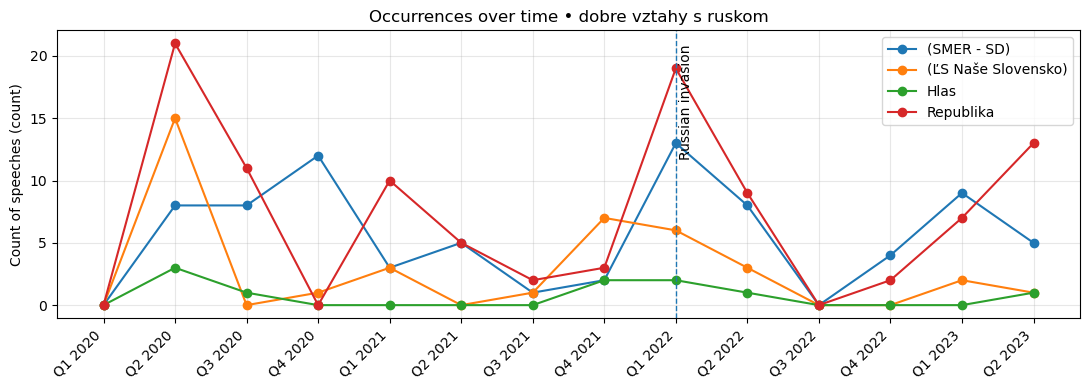

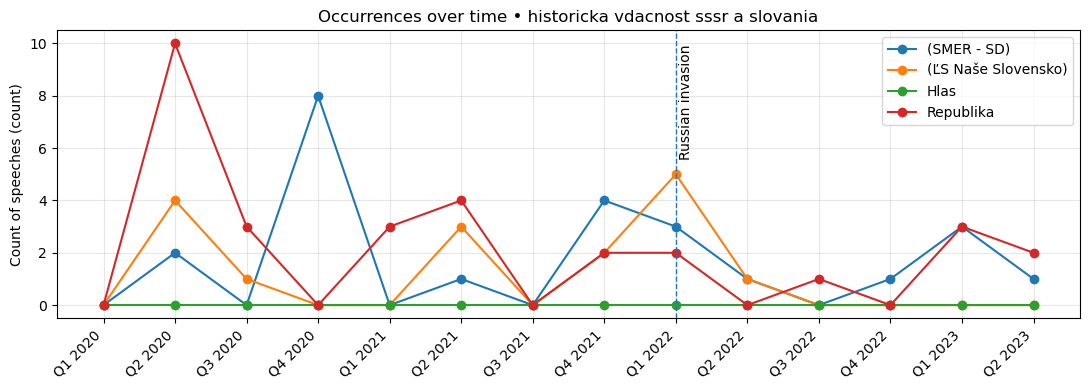

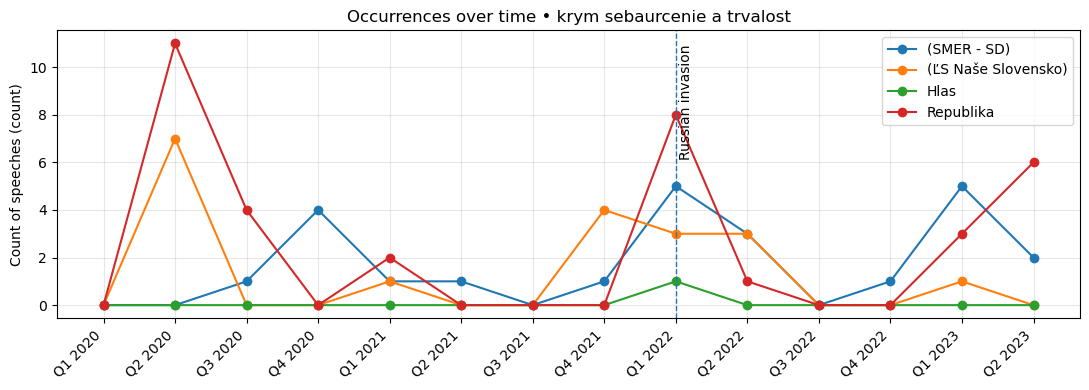

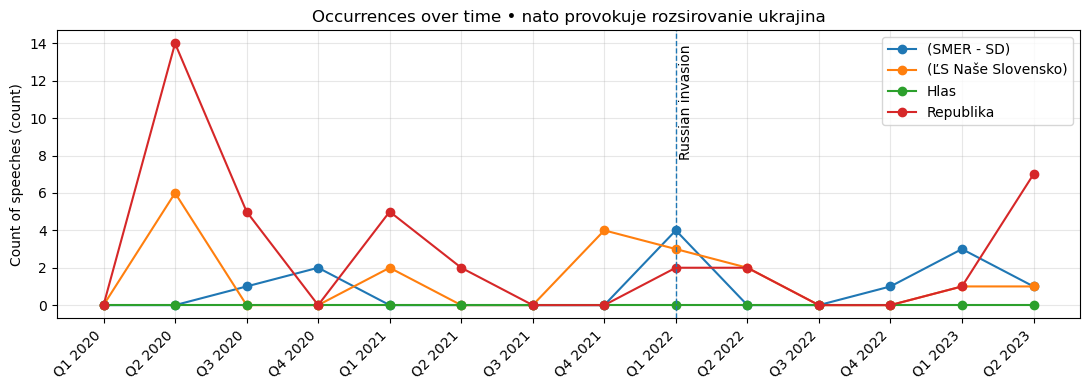

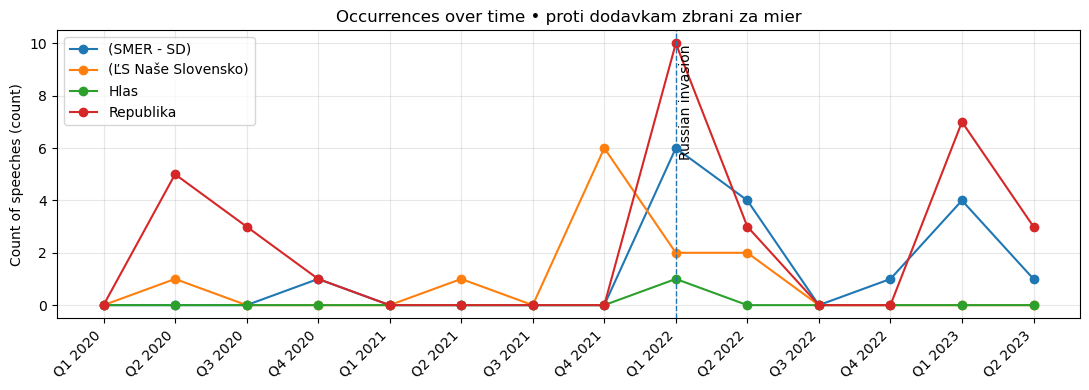

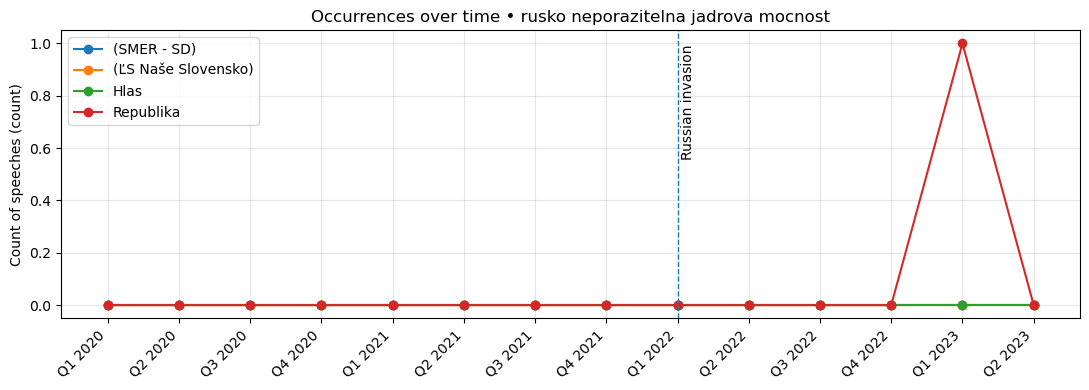

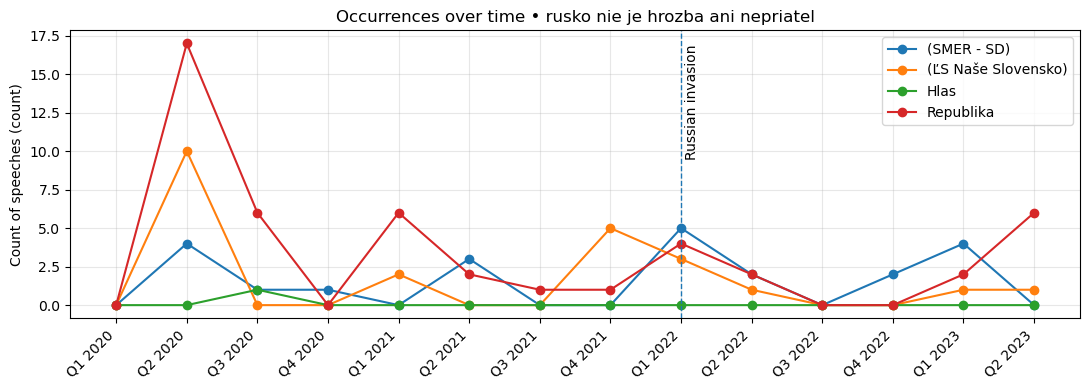

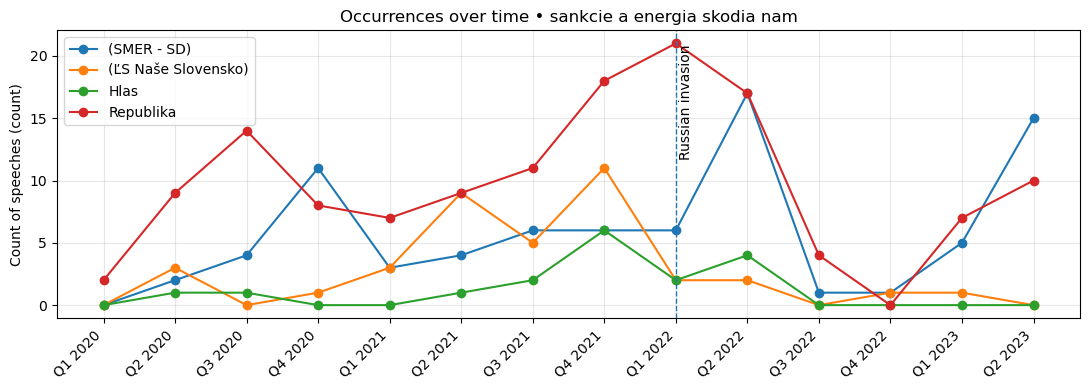

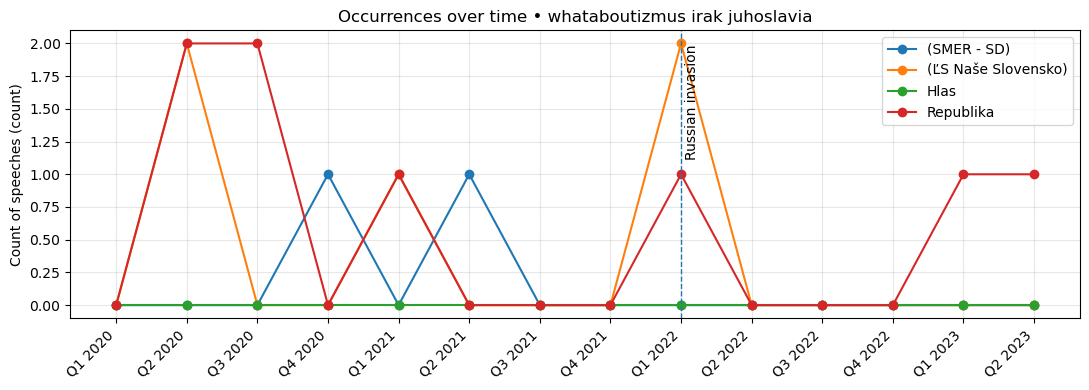

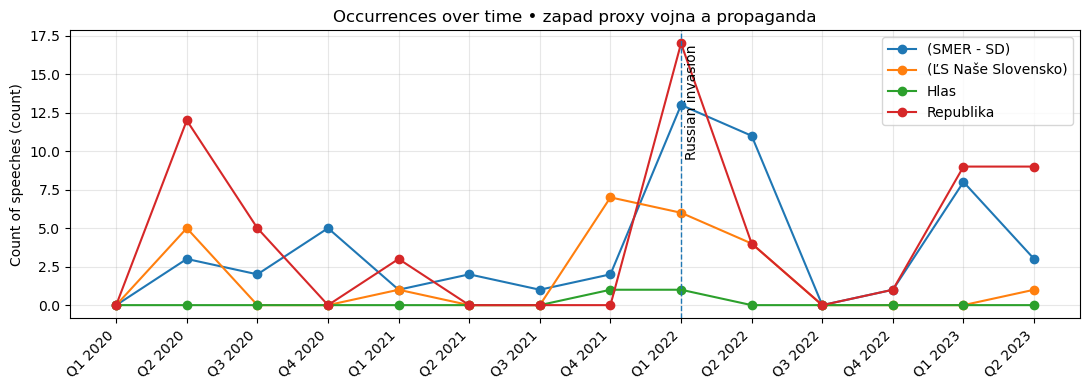

In [ ]:

long_df = build_narrative_long(df_with_categories)
g, q_order, q_starts = aggregate_counts(long_df)
plot_timelines_faceted_counts(
   g, q_order, q_starts,
    event_date="2022-02-24",
    event_label="Russian invasion" )
